<h2>About this Project</h2>

**In this Project, you will create a logistic regression classifier that can "filter" spam email messages.** Having focused on modeling in the previous projects, you will now dive deep into email data and preprocessing. **This project does not have any graded exercises.** Instead, you will review how different pieces -- data, modeling, evaluation -- tie up to produce a Machine Learning model.

At the end of the project is an ungraded challenge that we highly recommend! The goal is to improve than the naïve email classification by writing better a feature-extraction function.

<h2>Getting Started</h2>
<h3>Python Initialization</h3> 

Please run the following code to initialize your Python kernel. You should be running a version of Python 3.x. </p>

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 

from helper import *

print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.6.8


## Build an Spam Email Classifier - Project 3 (Spam Email Classifier)

### Load Data

With logistic regression implemented, you can now build an email spam filter using logistic regression. The functions below load in pre-processed email data from cloud storage. With the naïve email extraction function, the emails are represented as binary vectors. We split the email on whitespace to get constituent words, or "tokens", and set the token's feature to 1. This is called a "bag-of-words" representation. 

In [5]:
import pandas as pd
import dask
import dask.bag
from dask.diagnostics import ProgressBar

train_url = 's3://codio/CIS530/CIS533/data_train'
test_url = 's3://codio/CIS530/CIS533/data_test'

In [6]:
# tokenize the email and hashes the symbols into a vector
def extract_features_naive(email, B):
    '''
    Returns a vector representation for email. The vector is of length B.
    
    Input:
        email: list of lines in an email
        B: number of dimensions of output vector
        
    Output:
        B-dimensional vector
    '''
    # initialize all-zeros feature vector
    v = np.zeros(B)
    email = ' '.join(email)
    
    # breaks for non-ascii characters
    tokens = email.split()
    for token in tokens:
        v[hash(token) % B] = 1
    return v


def load_spam_data(extract_features, B=512, url=train_url):
    '''
    Loads email data from url and extracts features using the extract_features function.
    
    Input:
        extractfeatures: function to extract features
        B: (optional, default 512) dimensionality of feature space
        url: (optional, default train_url) path to the data
    
    Output:
        xs, ys, contents
        xs: data matrix of shape nxB where n is the number of emails
        ys: n labels (+1 for spam or -1 for non-spam)
        contents: all unprocessed emails
    '''
    
    all_emails = pd.read_csv(os.path.join(url, 'index'), header=None).values.flatten()
    
    xs = np.zeros((len(all_emails), B))
    ys = np.zeros(len(all_emails))
    
    labels = [k.split()[0] for k in all_emails]
    paths = [os.path.join(url, k.split()[1]) for k in all_emails]

    ProgressBar().register()
    dask.config.set(scheduler='threads', num_workers=50)
    bag = dask.bag.read_text(paths, storage_options={'anon': True})
    contents = dask.bag.compute(*bag.to_delayed())
    for i, email in enumerate(contents):
        # make labels +1 for "spam" and -1 for "non-spam" (convert from 0, 1 to -1, +1)
        ys[i] = (labels[i] == 'spam') * 2 - 1
        xs[i, :] = extract_features(email, B)
    print('Loaded %d input emails.' % len(ys))
    return xs, ys, contents

Xspam, Yspam, contents = load_spam_data(extract_features_naive)

[########################################] | 100% Completed | 57.7s
Loaded 5000 input emails.


### First, let's inspect the data.

In [5]:
print(Xspam.shape)
print(Yspam[0], 'spam' if Yspam[0] > 0 else 'non-spam')
print(np.array(contents[0]))
print(Xspam)

(5000, 512)
1.0 spam
['From paulson6@arabia.com  Mon Jun 25 13:11:28 2001\n'
 'Return-Path: <paulson6@arabia.com>\n'
 'Delivered-To: yyyy@netnoteinc.com\n'
 'Received: from exchange.harbin.cc (unknown [202.97.247.130]) by\n'
 '    mail.netnoteinc.com (Postfix) with ESMTP id CABAA114155 for\n'
 '    <jm7@netnoteinc.com>; Mon, 25 Jun 2001 12:18:19 +0100 (IST)\n'
 'Received: from 207.173.146.92 (eli-207-173-146-92.fgn.net\n'
 '    [207.173.146.92]) by exchange.harbin.cc with SMTP (Microsoft Exchange\n'
 '    Internet Mail Service Version 5.5.2650.21) id NM8LGL9X; Mon,\n'
 '    25 Jun 2001 18:26:25 +0800\n'
 'Message-Id: <0000104257bd$00001f24$00007177@>\n'
 'To: <Undisclosed Recipients@netnoteinc.com>\n'
 'From: paulson6@arabia.com\n'
 'Subject: *THE LEGAL CABLE TV DESCRAMBLER*\n'
 'Date: Sun, 24 Jun 2001 20:45:01 -0700\n' 'MIME-Version: 1.0\n'
 'Content-Transfer-Encoding: quoted-printable\n' 'X-Priority: 3\n'
 'X-Msmail-Priority: Normal\n' '\n' '\n' '<HTML>\n' '<BODY>\n' '\n'
 '<FONT fac

### Split The Dataset

Now that you have loaded the dataset, it's time to split it into training and testing. Run the code below to split of 20% of the data into a validation set, leaving 80% as your training set. Unlike a testing that is hidden and is used to evaluate your final algorithm once at the end, the validation set is available and can be used to evaluate and tune parameters like the learning rate for your model.

You will train the model on the training set and evaluate on the validation set. You can repeatedly do so and improve the model's performance. A validation set is thus like a testing test but is split off from the full training set. That is why you have access to the validation set but not to the real testing set.

In [11]:
# Split data into training (xTr and yTr) and validation (xTv and yTv)
n, d = Xspam.shape

# Set the seed for consistency across runs, and shuffle the dataset randomly
np.random.seed(1)
shuffle_idxs = np.random.permutation(n)
Xspam = Xspam[shuffle_idxs]
Yspam = Yspam[shuffle_idxs]

# Allocate 80% of the data for training and 20% for testing
cutoff = int(np.ceil(0.8 * n))
# indices of training samples
xTr = Xspam[:cutoff, :]
yTr = Yspam[:cutoff]
# indices of Validation samples
xTv = Xspam[cutoff:, :]
yTv = Yspam[cutoff:]

### Training and Evaluating

Running the following cell will produce a logistic regression model that can classify unseen emails (validation set) at roughly 90% validation accuracy.

Training accuracy 97.88%
Validation accuracy 95.00%



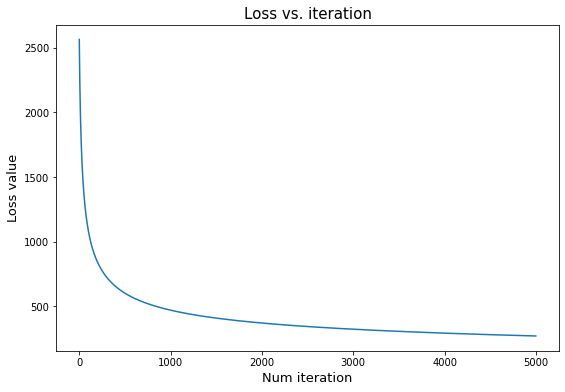

In [12]:
max_iter = 5000
alpha = 1e-5
final_w_spam, final_b_spam, losses = logistic_regression_grader(xTr, yTr, max_iter, alpha)

plt.figure(figsize=(9, 6))
plt.plot(losses)
plt.title("Loss vs. iteration", size=15)
plt.xlabel("Num iteration", size=13)
plt.ylabel("Loss value", size=13)

# evaluate training accuracy
scoresTr = y_pred_grader(xTr, final_w_spam, final_b_spam)
pred_labels = (scoresTr > 0.5).astype(int)
pred_labels[pred_labels != 1] = -1
trainingacc = np.mean(pred_labels == yTr)

# evaluate validation accuracy
scoresTv = y_pred_grader(xTv, final_w_spam, final_b_spam)
pred_labels = (scoresTv > 0.5).astype(int)
pred_labels[pred_labels != 1] = -1
validationacc = np.mean(pred_labels == yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100, validationacc*100))

## Scikit-learn example

Scikit-learn actually provides two implementations of Logistic Regression: as [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and as [`sklearn.linear_model.SGDClassifier(loss='log')`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html). The former uses second-order gradient methods (using the second derivative of $NLL$) to converge faster. We will demonstrate using the latter implementation so that you get similar results to the classifier you built.

In [13]:
from sklearn.linear_model import SGDClassifier

regularizer_multiplier = 0.
clf = SGDClassifier(
    loss='log', # Logistic Regression
    tol=None, # Run to max_iter
    alpha=regularizer_multiplier, # Don't use L2 or L1 regularizer
    learning_rate='constant', eta0=alpha, # Constant learning rate
    max_iter=max_iter
)
clf.fit(xTr, yTr)
final_w_sklearn, final_b_sklearn = clf.coef_.flatten(), clf.intercept_.flatten()

# evaluate training accuracy
scoresTr = y_pred_grader(xTr, final_w_sklearn, final_b_sklearn)
pred_labels = (scoresTr > 0.5).astype(int)
pred_labels[pred_labels != 1] = -1
trainingacc = np.mean(pred_labels == yTr)

# evaluate testing accuracy
scoresTv = y_pred_grader(xTv, final_w_sklearn, final_b_sklearn)
pred_labels = (scoresTv > 0.5).astype(int)
pred_labels[pred_labels != 1] = -1
validationacc = np.mean(pred_labels == yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100, validationacc*100))

Training accuracy 97.85%
Validation accuracy 95.00%



## Challenge: Improve Your Spam Classifier **[Ungraded]**

You can improve your classifier in two ways:

1. **Feature Extraction**: Modify the function `extract_features_challenge()`. This function takes in a `email` (list of lines in an email) and a feature dimension `B`, and should output a feature vector of dimension `B`. The autograder will pass in both arguments. We provide naive feature extraction from above as an example.
2. **Model Training**: Modify the function `train_spam_filter_challenge()`. This function takes in training data `xTr, yTr` and should output a weight vector `w` and bias term `b` for classification. The predictions will be calculated exactly the same way as we have demonstrated in the previous cell. We provide an initial implementation using gradient descent and logistic regression.

Your model will be trained on the same training set above (loaded by `load_spam_data()`), but we will test its accuracy on a testing dataset of emails (hidden from you).

In [34]:
feature_dimension = 512
def extract_features_challenge(email, B=feature_dimension):
    '''
    Returns a vector representation for email. The vector is of length B.
    
    Input:
        email: list of lines in an email
        B: number of dimensions of output vector
        
    Output:
        B-dimensional vector
    '''
    # initialize all-zeros feature vector
    v = np.zeros(B)
    email = ' '.join(email)
    # breaks for non-ascii characters
    tokens = email.split()
    for token in tokens:
        v[hash(token) % B] = 1
        
    # YOUR CODE HERE
#     num_ex = email.count('!')
#     num_qs = email.count('?')
    
#     v[-1] = np.exp(-num_ex)
#     v[-2] = np.exp(-num_qs)
    
    return v

In [35]:
feature_dimension = 512
def extract_features_challenge2(email, B=feature_dimension):
    '''
    Returns a vector representation for email. The vector is of length B.
    
    Input:
        email: list of lines in an email
        B: number of dimensions of output vector
        
    Output:
        B-dimensional vector
    '''
    # initialize all-zeros feature vector
    v = np.zeros(B)
    email = ' '.join(email)
    # breaks for non-ascii characters
    tokens = email.split()
    for token in tokens:
        v[hash(token) % (B-2)] = 1
        
    # YOUR CODE HERE
    num_ex = email.count('!')
    num_qs = email.count('?')
    
    v[-1] = np.exp(-num_ex)
    v[-2] = np.exp(-num_qs)
    
    return v

In [36]:
def train_spam_filter_challenge(xTr, yTr):
    '''
    Train a model on training data xTr and labels yTr, and return weight vector and bias term.
    
    Input:
        xTr: data matrix of shape nxd
        yTr: n-dimensional vector data labels (+1 or -1)
        
    Output:
        w, b
        w: d-dimension weight vector
        b: scalar bias term
    '''
    n, d = xTr.shape
    
    max_iter = 100
    alpha = 1e-5
    w, b, losses = logistic_regression_grader(xTr, yTr, max_iter, alpha)
    
        
    # YOUR CODE HERE

    return w, b


In [37]:
def train_spam_filter_challenge2(xTr, yTr):
    '''
    Train a model on training data xTr and labels yTr, and return weight vector and bias term.
    
    Input:
        xTr: data matrix of shape nxd
        yTr: n-dimensional vector data labels (+1 or -1)
        
    Output:
        w, b
        w: d-dimension weight vector
        b: scalar bias term
    '''
    n, d = xTr.shape
    
    max_iter = 100
    alpha = 1e-5
#     w, b, losses = logistic_regression_grader(xTr, yTr, max_iter, alpha)
    
        
    # YOUR CODE HERE
    w = np.zeros(d)
    b = 0.0
    iter = 0
    seq = np.random.permutation(n)
    xTr = xTr[seq]
    yTr = yTr[seq]
    
    while True:
        iter += 1
        m = 0
        for i in range(n):
            if yTr[i]*(np.dot(xTr[i], w) + b) <= 0:
                w += yTr[i]*xTr[i]
                b += yTr[i]
                m+=1
        if m == 0:
            break
        elif iter == 100:
            break
    return w, b

In [38]:
def challenge_selftest():
    xTr, yTr, cTr = load_spam_data(extract_features_challenge, feature_dimension, train_url)
    w, b = train_spam_filter_challenge(xTr, yTr)
    xTe, yTe, cTe = load_spam_data(extract_features_challenge, feature_dimension, test_url)
    scoresTe = sigmoid_grader(xTe @ w + b)
    
    preds = (scoresTe > 0.5).astype(int)
    preds[preds != 1] = -1
    
    pos_ind = (yTe == 1)
    neg_ind = (yTe == -1)
    
    pos_acc = np.mean(yTe[pos_ind] == preds[pos_ind])
    neg_acc = np.mean(yTe[neg_ind] == preds[neg_ind])
    
    test_accuracy = 0.5*pos_acc + 0.5*neg_acc
    
    scoresTr =  sigmoid_grader(xTr @ w + b)
    preds_Tr = (scoresTr > 0.5).astype(int)
    preds_Tr[preds_Tr != 1] = -1
    
    training_accuracy = np.mean(preds_Tr == yTr)
    return training_accuracy, test_accuracy

training_acc, test_acc = challenge_selftest()
print("Your features and model achieved training accuracy: {:.2f}% and test accuracy: {:.2f}%".format(training_acc*100, test_acc*100))

[########################################] | 100% Completed |  1min 26.6s
[########################################] | 100% Completed |  1min 26.6s
[########################################] | 100% Completed |  1min 26.7s
[########################################] | 100% Completed |  1min 26.8s
[########################################] | 100% Completed |  1min 26.8s
[########################################] | 100% Completed |  1min 26.9s
[########################################] | 100% Completed |  1min 27.0s
[########################################] | 100% Completed |  1min 27.0s
[########################################] | 100% Completed |  1min 27.1s
[########################################] | 100% Completed |  1min 27.1s
[########################################] | 100% Completed |  1min 27.2s
[########################################] | 100% Completed |  1min 27.3s
[########################################] | 100% Completed |  1min 27.3s
[#####################################

In [40]:
def challenge_selftest2():
    xTr, yTr, cTr = load_spam_data(extract_features_challenge2, feature_dimension, train_url)
    w, b = train_spam_filter_challenge(xTr, yTr)
    xTe, yTe, cTe = load_spam_data(extract_features_challenge2, feature_dimension, test_url)
    scoresTe = sigmoid_grader(xTe @ w + b)
    
    preds = (scoresTe > 0.5).astype(int)
    preds[preds != 1] = -1
    
    pos_ind = (yTe == 1)
    neg_ind = (yTe == -1)
    
    pos_acc = np.mean(yTe[pos_ind] == preds[pos_ind])
    neg_acc = np.mean(yTe[neg_ind] == preds[neg_ind])
    
    test_accuracy = 0.5*pos_acc + 0.5*neg_acc
    
    scoresTr =  sigmoid_grader(xTr @ w + b)
    preds_Tr = (scoresTr > 0.5).astype(int)
    preds_Tr[preds_Tr != 1] = -1
    
    training_accuracy = np.mean(preds_Tr == yTr)
    return training_accuracy, test_accuracy

training_acc, test_acc = challenge_selftest2()
print("Your features and model achieved training accuracy: {:.2f}% and test accuracy: {:.2f}%".format(training_acc*100, test_acc*100))

[########################################] | 100% Completed |  1min 27.1s
[########################################] | 100% Completed |  1min 27.1s
[########################################] | 100% Completed |  1min 27.1s
[########################################] | 100% Completed |  1min 27.2s
[########################################] | 100% Completed |  1min 27.3s
[########################################] | 100% Completed |  1min 27.3s
[########################################] | 100% Completed |  1min 27.4s
[########################################] | 100% Completed |  1min 27.5s
[########################################] | 100% Completed |  1min 27.5s
[########################################] | 100% Completed |  1min 27.6s
[########################################] | 100% Completed |  1min 27.6s
[########################################] | 100% Completed |  1min 27.7s
[########################################] | 100% Completed |  1min 27.8s
[#####################################

In [42]:
def challenge_selftest3():
    xTr, yTr, cTr = load_spam_data(extract_features_challenge, feature_dimension, train_url)
    w, b = train_spam_filter_challenge2(xTr, yTr)
    xTe, yTe, cTe = load_spam_data(extract_features_challenge, feature_dimension, test_url)
    scoresTe = sigmoid_grader(xTe @ w + b)
    
    preds = (scoresTe > 0.5).astype(int)
    preds[preds != 1] = -1
    
    pos_ind = (yTe == 1)
    neg_ind = (yTe == -1)
    
    pos_acc = np.mean(yTe[pos_ind] == preds[pos_ind])
    neg_acc = np.mean(yTe[neg_ind] == preds[neg_ind])
    
    test_accuracy = 0.5*pos_acc + 0.5*neg_acc
    
    scoresTr =  sigmoid_grader(xTr @ w + b)
    preds_Tr = (scoresTr > 0.5).astype(int)
    preds_Tr[preds_Tr != 1] = -1
    
    training_accuracy = np.mean(preds_Tr == yTr)
    return training_accuracy, test_accuracy

training_acc, test_acc = challenge_selftest3()
print("Your features and model achieved training accuracy: {:.2f}% and test accuracy: {:.2f}%".format(training_acc*100, test_acc*100))

[########################################] | 100% Completed |  1min 44.1s
[########################################] | 100% Completed |  1min 44.1s
[########################################] | 100% Completed |  1min 44.1s
[########################################] | 100% Completed |  1min 44.2s
[########################################] | 100% Completed |  1min 44.2s
[########################################] | 100% Completed |  1min 44.2s
[########################################] | 100% Completed |  1min 44.3s
[########################################] | 100% Completed |  1min 44.4s
[########################################] | 100% Completed |  1min 44.5s
[########################################] | 100% Completed |  1min 44.5s
[########################################] | 100% Completed |  1min 44.6s
[########################################] | 100% Completed |  1min 44.6s
[########################################] | 100% Completed |  1min 44.6s
[#####################################

/home/codio/workspace/helper.py:24: RuntimeWarning: overflow encountered in exp
  sgmd = 1 / (1 + np.exp(-z))


In [41]:
def challenge_selftest4():
    xTr, yTr, cTr = load_spam_data(extract_features_challenge2, feature_dimension, train_url)
    w, b = train_spam_filter_challenge2(xTr, yTr)
    xTe, yTe, cTe = load_spam_data(extract_features_challenge2, feature_dimension, test_url)
    scoresTe = sigmoid_grader(xTe @ w + b)
    
    preds = (scoresTe > 0.5).astype(int)
    preds[preds != 1] = -1
    
    pos_ind = (yTe == 1)
    neg_ind = (yTe == -1)
    
    pos_acc = np.mean(yTe[pos_ind] == preds[pos_ind])
    neg_acc = np.mean(yTe[neg_ind] == preds[neg_ind])
    
    test_accuracy = 0.5*pos_acc + 0.5*neg_acc
    
    scoresTr =  sigmoid_grader(xTr @ w + b)
    preds_Tr = (scoresTr > 0.5).astype(int)
    preds_Tr[preds_Tr != 1] = -1
    
    training_accuracy = np.mean(preds_Tr == yTr)
    return training_accuracy, test_accuracy

training_acc, test_acc = challenge_selftest4()
print("Your features and model achieved training accuracy: {:.2f}% and test accuracy: {:.2f}%".format(training_acc*100, test_acc*100))

[########################################] | 100% Completed |  1min 35.7s
[########################################] | 100% Completed |  1min 35.7s
[########################################] | 100% Completed |  1min 35.8s
[########################################] | 100% Completed |  1min 35.9s
[########################################] | 100% Completed |  1min 35.9s
[########################################] | 100% Completed |  1min 36.0s
[########################################] | 100% Completed |  1min 36.1s
[########################################] | 100% Completed |  1min 36.1s
[########################################] | 100% Completed |  1min 36.1s
[########################################] | 100% Completed |  1min 36.1s
[########################################] | 100% Completed |  1min 36.1s
[########################################] | 100% Completed |  1min 36.2s
[########################################] | 100% Completed |  1min 36.3s
[#####################################

/home/codio/workspace/helper.py:24: RuntimeWarning: overflow encountered in exp
  sgmd = 1 / (1 + np.exp(-z))
